___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

# Concrete Slump Test Regression

The concrete slump test measures the consistency of fresh concrete before it sets. It is performed to check the workability of freshly made concrete, and therefore the ease with which concrete flows. It can also be used as an indicator of an improperly mixed batch.

<img src="https://i0.wp.com/civiconcepts.com/wp-content/uploads/2019/08/Slump-Cone-test-of-concrete.jpg?fit=977%2C488&ssl=1">

Our data set consists of various cement properties and the resulting slump test metrics in cm. Later on the set concrete is tested for its compressive strength 28 days later.

Input variables (9):

(component kg in one M^3 concrete)(7):
* Cement
* Slag
* Fly ash
* Water
* SP
* Coarse Aggr.
* Fine Aggr.

(Measurements)(2)
* SLUMP (cm)
* FLOW (cm)

Target variable (1):
* **28-day Compressive Strength (Mpa)**

Data Source: https://archive.ics.uci.edu/ml/datasets/Concrete+Slump+Test

*Credit: Yeh, I-Cheng, "Modeling slump flow of concrete using second-order regressions and artificial neural networks," Cement and Concrete Composites, Vol.29, No. 6, 474-480, 2007.*

# Importing dependencies

# Loading data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
# %matplotlib notebook

from scipy import stats

#!pip install termcolor
import colorama
from colorama import Fore, Style  # makes strings colored
from termcolor import colored
from termcolor import cprint

# plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("cement_slump.csv")

In [3]:
df0=pd.read_csv('cement_slump.csv')
df = df0.copy()

In [4]:
df.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.000,82.000,105.000,210.000,9.000,904.000,680.000,23.000,62.000,34.990
1,163.000,149.000,191.000,180.000,12.000,843.000,746.000,0.000,20.000,41.140
2,162.000,148.000,191.000,179.000,16.000,840.000,743.000,1.000,20.000,41.810
3,162.000,148.000,190.000,179.000,19.000,838.000,741.000,3.000,21.500,42.080
4,154.000,112.000,144.000,220.000,10.000,923.000,658.000,20.000,64.000,26.820


In [5]:
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

In [6]:
def first_looking(df):
    print(colored("Shape:", 'yellow', attrs=['bold']), df.shape,'\n', 
          colored('*'*100, 'red', attrs=['bold']),
          colored("\nInfo:\n",'yellow', attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", 'yellow', attrs=['bold']), df.nunique(),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='')
#     print(colored("Missing Values:\n", 'yellow', attrs=['bold']), missing_values(df),'\n', 
#           colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", 'yellow', attrs=['bold']), *list(df.columns), sep='\n- ') 
    print(colored('*'*100, 'red', attrs=['bold']), sep='')

#     df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
    
#     print(colored("Columns after rename:", 'yellow', attrs=['bold']), *list(df.columns), sep='\n- ')
#     print(colored('*'*100, 'red', attrs=['bold']), sep='')

In [7]:
## To view summary information about the columns

def summary(column):
    print(colored("Column: ",'yellow', attrs=['bold']), column)
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values: ", 'yellow', attrs=['bold']), df[column].isnull().sum())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values(%): ", 'yellow', attrs=['bold']), round(df[column].isnull().sum()/df.shape[0]*100, 2))
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Unique values: ", 'yellow', attrs=['bold']), df[column].nunique())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Value counts: \n", 'yellow', attrs=['bold']), df[column].value_counts(dropna = False), sep='')
    print(colored('*'*100, 'red', attrs=['bold']), sep='')

In [8]:
## To view summary_ information about the columns

def summary_(column):
    print(colored("Column: ",'yellow', attrs=['bold']), column)
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values: ", 'yellow', attrs=['bold']), df[column].isnull().sum())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values(%): ", 'yellow', attrs=['bold']), round(df[column].isnull().sum()/df.shape[0]*100, 2))
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Unique values: ", 'yellow', attrs=['bold']), df[column].nunique())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')

In [9]:
def multicolinearity_control(df):                    
    df_temp = df.corr()
    count = 'Done'
    feature =[]
    collinear= []
    for col in df_temp.columns:
        for i in df_temp.index:
            if abs(df_temp[col][i] > .9 and df_temp[col][i] < 1):
                    feature.append(col)
                    collinear.append(i)
                    cprint(f"Multicolinearity alert in between --> {col} - {i} --> {round(df_temp[col][i], 6)}", "red", attrs=["bold"])
    else:
#         cprint(f"There is NO multicollinearity problem.", "blue", attrs=["bold"])
        pass

In [10]:
def duplicate_values(df):
    print(colored("Duplicate check...", 'yellow', attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored(" Duplicates were dropped!"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There is no duplicate value"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')  

In [11]:
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('Missing value control...', 'yellow', attrs=['bold']),'\n',
              colored('If there is a missing value above the limit you have given, the relevant columns are dropped and an information is given.'), sep='')

In [12]:
def drop_null(df, limit):
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'were null and dropped')
            df.drop(i, axis=1, inplace=True)
    print(colored('Last shape after missing value control:', 'yellow', attrs=['bold']), df.shape, '\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')

In [13]:
def shape_control():
    print('df.shape:', df.shape)
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    print('X_test.shape:', X_test.shape)
    print('y_test.shape:', y_test.shape)

In [14]:
## show values in bar graphic
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [15]:
def missing_values(df):
#     print(colored("Missing value check...", 'yellow', attrs=['bold']), sep='')
    missing_values = df.isnull().sum().values.sum()
    if missing_values > 0:
        print(missing_values, colored(" Duplicates were dropped!"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There is no missing value"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')  

In [16]:
def color_red(val):
    
    if (val > 0.90 and val < 0.99) or (val < -0.90 and val > -0.99):
        color = 'red'
    else:
        color = 'black'
    return f'color: {color}'

# %90 ve üzeri bir korelasyon multicollinearity göstergesi olarak değerlendirilebilir.

In [17]:
def show_distribution_density(col):

    min_val = col.min()
    max_val = col.max()
    mean_val = col.mean()
    med_val = col.median()
    mod_val = col.mode()[0]

    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    fig = plt.figure(figsize = (15,10))
    
    plt.subplot(3, 1, 1)
    plt.hist(col)
    plt.ylabel('Frequency', fontsize=10)
    plt.axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Minimum')
    plt.axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2, label='Mean')
    plt.axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2, label='Median')
    plt.axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2, label='Mode')
    plt.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Maximum')
    plt.legend(loc='upper right')
    
    plt.subplot(3, 1, 2) 
    plt.boxplot(col, vert=False)
    
    plt.subplot(3, 1, 3)
    col.plot.density()
    plt.axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Minimum')
    plt.axvline(x=col.mean(), color = 'cyan', linestyle='dashed', linewidth = 2, label = 'Mean')
    plt.axvline(x=col.median(), color = 'red', linestyle='dashed', linewidth = 2, label = 'Median')
    plt.axvline(x=col.mode()[0], color = 'yellow', linestyle='dashed', linewidth = 2, label = 'Mode')
    plt.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Maximum')
    plt.legend(loc='upper right')

    fig.suptitle('Column Distribution & Density', fontsize=15)
    
    plt.show() 

In [18]:
def show_density(col):

    fig = plt.figure(figsize=(15,5))

    df[col].plot.density()

    plt.title('Data Density', fontsize=15)

    plt.axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Minimum')
    plt.axvline(x=col.mean(), color = 'cyan', linestyle='dashed', linewidth = 2, label = 'Mean')
    plt.axvline(x=col.median(), color = 'red', linestyle='dashed', linewidth = 2, label = 'Median')
    plt.axvline(x=col.mode()[0], color = 'yellow', linestyle='dashed', linewidth = 2, label = 'Mode')
    plt.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Maximum')
    plt.legend(loc='upper right')

    plt.show()

In [19]:
def outlier(col):
    print('Num_Outliers:', len(list(i for i in col if i > (np.percentile(col, 75) + 1.5 * stats.iqr(col)) or \
                              i < (np.percentile(col, 25) - 1.5 * stats.iqr(col)))))

    print('Outliers    :', sorted(list(i for i in col if i > (np.percentile(col, 75) + 1.5 * stats.iqr(col)) or \
                              i < (np.percentile(col, 25) - 1.5 * stats.iqr(col)))))

In [20]:
def train_val(y_train, y_train_pred, y_test, y_pred, model_name):
    
    scores = {model_name+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    model_name+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [62]:
#!pip install skimpy

In [21]:
from skimpy import clean_columns

columns = ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse', 'Fine', 'SLUMP',
           'FLOW', 'compressive_strength']

messy_df = pd.DataFrame(data=[], columns=columns, index=[0])
clean_df = clean_columns(messy_df)
clean_df.columns.tolist()


9 column names have been cleaned

['cement',
 'slag',
 'fly_ash',
 'water',
 'sp',
 'coarse',
 'fine',
 'slump',
 'flow',
 'compressive_strength']

In [22]:
df.columns = clean_df.columns.tolist()
df.columns

Index(['cement', 'slag', 'fly_ash', 'water', 'sp', 'coarse', 'fine', 'slump',
       'flow', 'compressive_strength'],
      dtype='object')

# EDA and Graphical analysis

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                103 non-null    float64
 1   slag                  103 non-null    float64
 2   fly_ash               103 non-null    float64
 3   water                 103 non-null    float64
 4   sp                    103 non-null    float64
 5   coarse                103 non-null    float64
 6   fine                  103 non-null    float64
 7   slump                 103 non-null    float64
 8   flow                  103 non-null    float64
 9   compressive_strength  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB


In [24]:
df.shape

(103, 10)

In [25]:
df.head()

,cement,slag,fly_ash,water,sp,coarse,fine,slump,flow,compressive_strength
0,273.000,82.000,105.000,210.000,9.000,904.000,680.000,23.000,62.000,34.990
1,163.000,149.000,191.000,180.000,12.000,843.000,746.000,0.000,20.000,41.140
2,162.000,148.000,191.000,179.000,16.000,840.000,743.000,1.000,20.000,41.810
3,162.000,148.000,190.000,179.000,19.000,838.000,741.000,3.000,21.500,42.080
4,154.000,112.000,144.000,220.000,10.000,923.000,658.000,20.000,64.000,26.820


In [26]:
df.tail()

,cement,slag,fly_ash,water,sp,coarse,fine,slump,flow,compressive_strength
98,248.300,101.000,239.100,168.900,7.700,954.200,640.600,0.000,20.000,49.970
99,248.000,101.000,239.900,169.100,7.700,949.900,644.100,2.000,20.000,50.230
100,258.800,88.000,239.600,175.300,7.600,938.900,646.000,0.000,20.000,50.500
101,297.100,40.900,239.900,194.000,7.500,908.900,651.800,27.500,67.000,49.170
102,348.700,0.100,223.100,208.500,9.600,786.200,758.100,29.000,78.000,48.700


In [27]:
df.columns

Index(['cement', 'slag', 'fly_ash', 'water', 'sp', 'coarse', 'fine', 'slump',
       'flow', 'compressive_strength'],
      dtype='object')

In [28]:
df.describe()

,cement,slag,fly_ash,water,sp,coarse,fine,slump,flow,compressive_strength
count,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000
mean,229.894,77.974,149.015,197.168,8.540,883.979,739.605,18.049,49.611,36.039
std,78.877,60.461,85.418,20.208,2.808,88.391,63.342,8.751,17.569,7.837
min,137.000,0.000,0.000,160.000,4.400,708.000,640.600,0.000,20.000,17.190
25%,152.000,0.050,115.500,180.000,6.000,819.500,684.500,14.500,38.500,30.900
50%,248.000,100.000,164.000,196.000,8.000,879.000,742.700,21.500,54.000,35.520
75%,303.900,125.000,235.950,209.500,10.000,952.800,788.000,24.000,63.750,41.205
max,374.000,193.000,260.000,240.000,19.000,1049.900,902.000,29.000,78.000,58.530


In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,103.000,229.894,78.877,137.000,152.000,248.000,303.900,374.000
slag,103.000,77.974,60.461,0.000,0.050,100.000,125.000,193.000
fly_ash,103.000,149.015,85.418,0.000,115.500,164.000,235.950,260.000
water,103.000,197.168,20.208,160.000,180.000,196.000,209.500,240.000
sp,103.000,8.540,2.808,4.400,6.000,8.000,10.000,19.000
coarse,103.000,883.979,88.391,708.000,819.500,879.000,952.800,1049.900
fine,103.000,739.605,63.342,640.600,684.500,742.700,788.000,902.000
slump,103.000,18.049,8.751,0.000,14.500,21.500,24.000,29.000
flow,103.000,49.611,17.569,20.000,38.500,54.000,63.750,78.000
compressive_strength,103.000,36.039,7.837,17.190,30.900,35.520,41.205,58.530


In [30]:
first_looking(df)

Shape:(103, 10)
****************************************************************************************************
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                103 non-null    float64
 1   slag                  103 non-null    float64
 2   fly_ash               103 non-null    float64
 3   water                 103 non-null    float64
 4   sp                    103 non-null    float64
 5   coarse                103 non-null    float64
 6   fine                  103 non-null    float64
 7   slump                 103 non-null    float64
 8   flow                  103 non-null    float64
 9   compressive_strength  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB
None
****************************************************************************************************
Number of Un

In [31]:
df.describe()

,cement,slag,fly_ash,water,sp,coarse,fine,slump,flow,compressive_strength
count,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000
mean,229.894,77.974,149.015,197.168,8.540,883.979,739.605,18.049,49.611,36.039
std,78.877,60.461,85.418,20.208,2.808,88.391,63.342,8.751,17.569,7.837
min,137.000,0.000,0.000,160.000,4.400,708.000,640.600,0.000,20.000,17.190
25%,152.000,0.050,115.500,180.000,6.000,819.500,684.500,14.500,38.500,30.900
50%,248.000,100.000,164.000,196.000,8.000,879.000,742.700,21.500,54.000,35.520
75%,303.900,125.000,235.950,209.500,10.000,952.800,788.000,24.000,63.750,41.205
max,374.000,193.000,260.000,240.000,19.000,1049.900,902.000,29.000,78.000,58.530


In [32]:
target='compressive_strength'

In [33]:
summary(target)

Column:  compressive_strength
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  83
****************************************************************************************************
Value counts: 
34.990    2
41.140    2
41.270    2
35.520    2
44.080    2
         ..
58.530    1
45.690    1
32.040    1
36.460    1
48.700    1
Name: compressive_strength, Length: 83, dtype: int64
****************************************************************************************************


Minimum:17.19
Mean:36.04
Median:35.52
Mode:26.42
Maximum:58.53



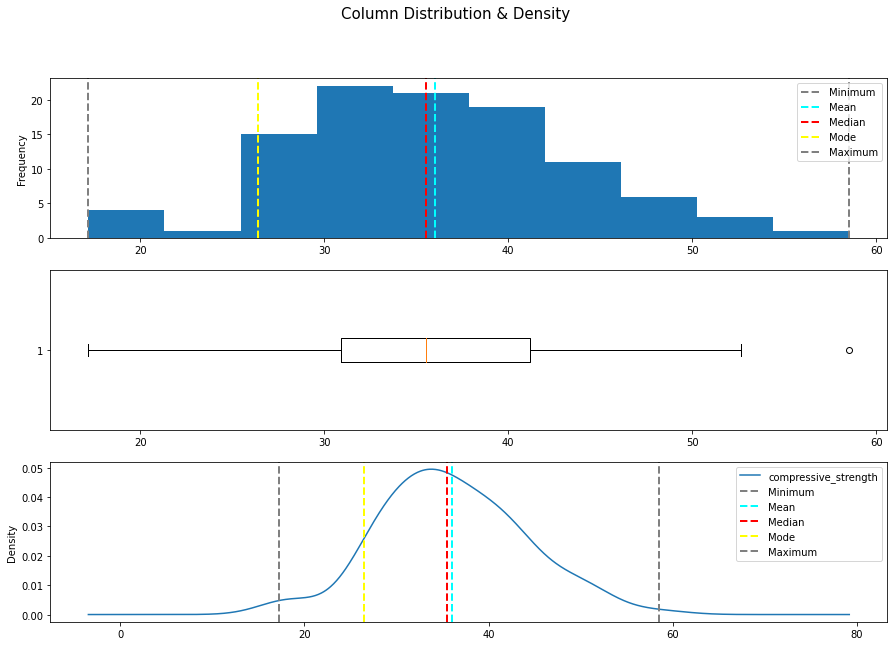

In [35]:
show_distribution_density(df['compressive_strength'])

mean median dan büyükse saga carpik

Minimum:137.00
Mean:229.89
Median:248.00
Mode:159.00
Maximum:374.00



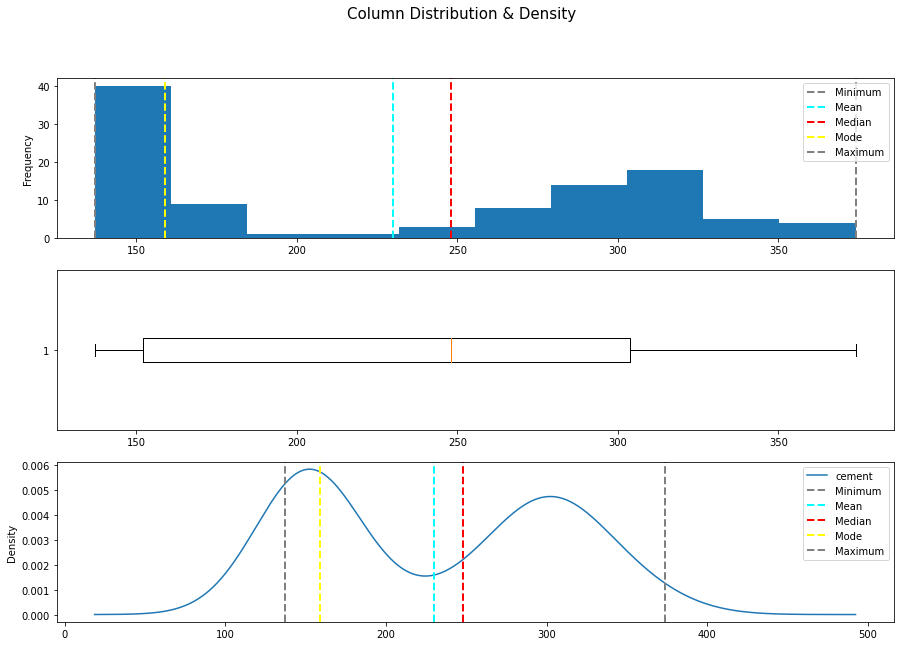

In [36]:
show_distribution_density(df['cement'])

Minimum:0.00
Mean:77.97
Median:100.00
Mode:0.00
Maximum:193.00



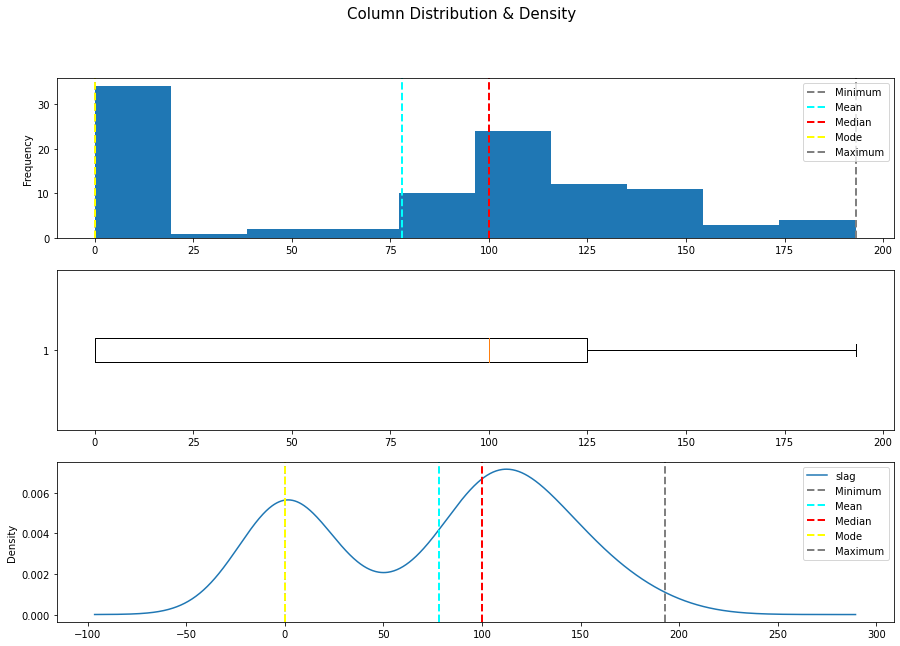

In [37]:
show_distribution_density(df['slag'])

Minimum:0.00
Mean:149.01
Median:164.00
Mode:0.00
Maximum:260.00



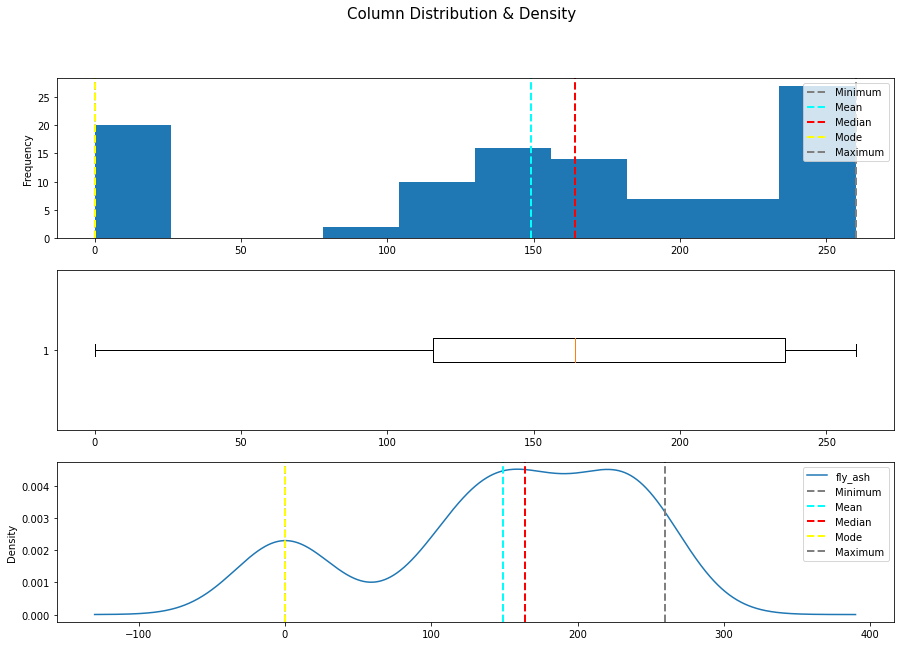

In [38]:
show_distribution_density(df['fly_ash'])

Minimum:160.00
Mean:197.17
Median:196.00
Mode:168.00
Maximum:240.00



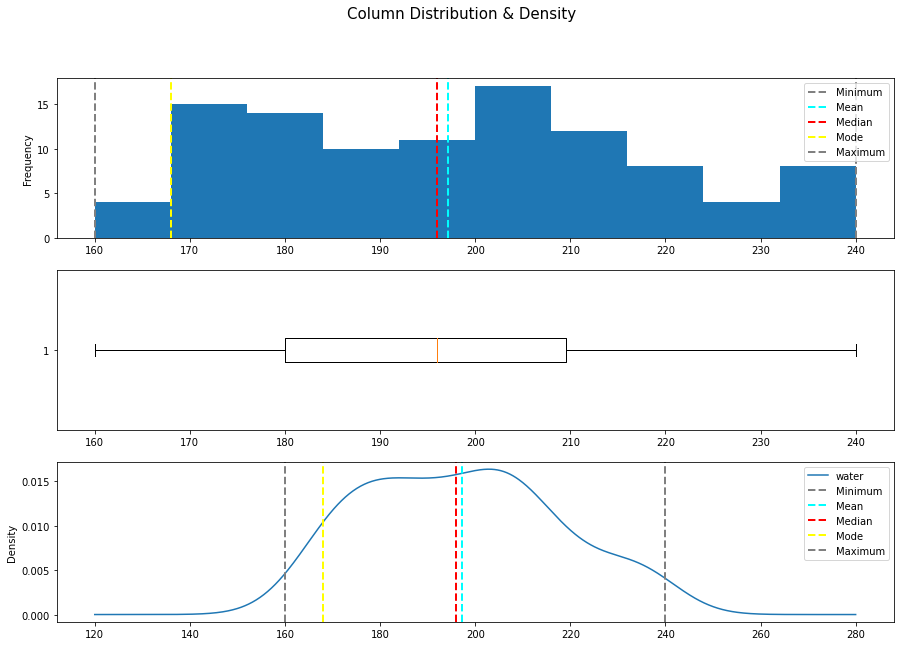

In [39]:
show_distribution_density(df['water'])

Minimum:4.40
Mean:8.54
Median:8.00
Mode:6.00
Maximum:19.00



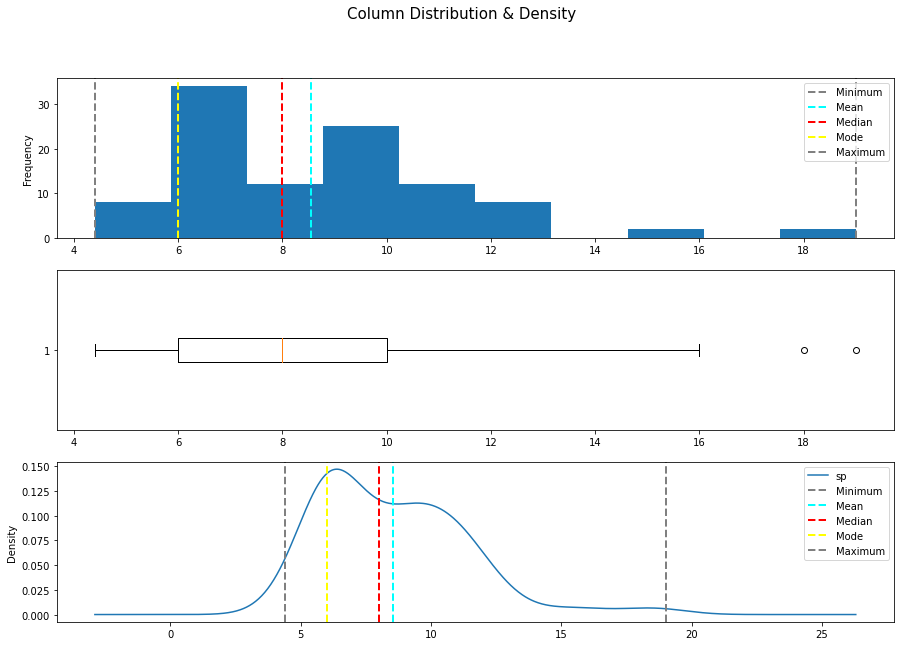

In [40]:
show_distribution_density(df['sp'])

Minimum:708.00
Mean:883.98
Median:879.00
Mode:904.00
Maximum:1049.90



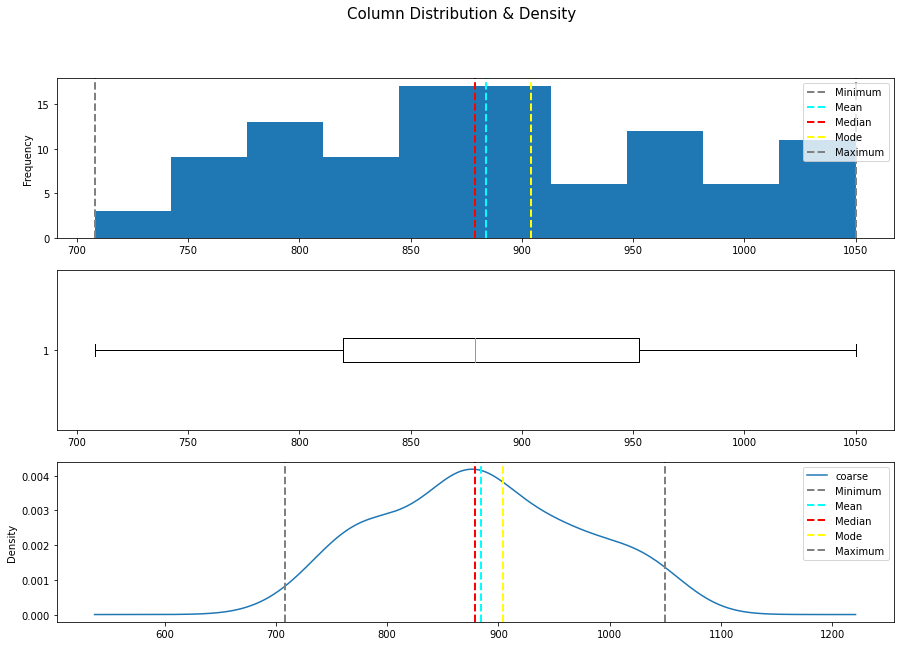

In [41]:
show_distribution_density(df['coarse'])

Minimum:640.60
Mean:739.60
Median:742.70
Mode:757.00
Maximum:902.00



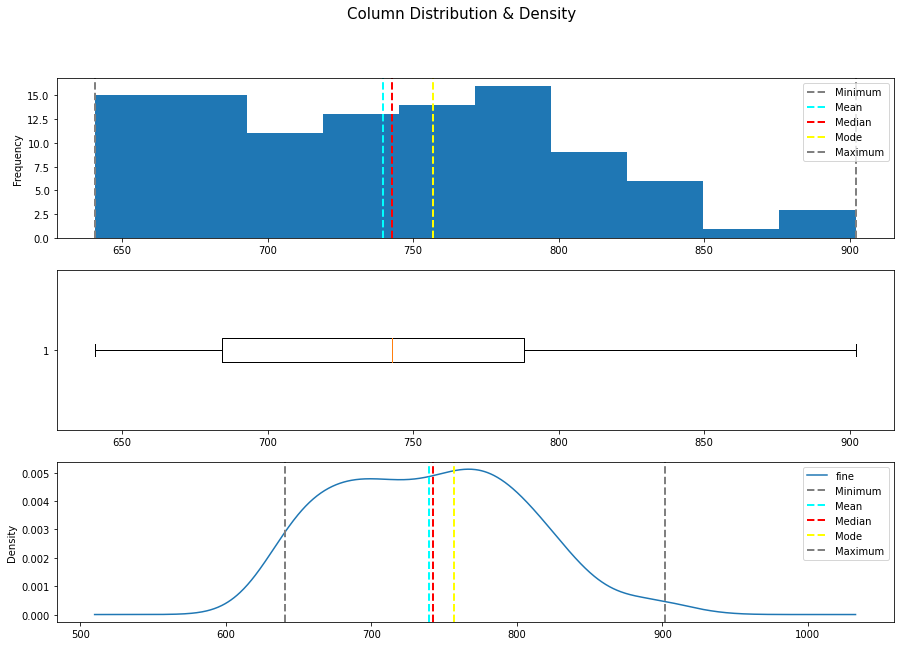

In [42]:
show_distribution_density(df['fine'])

Minimum:0.00
Mean:18.05
Median:21.50
Mode:0.00
Maximum:29.00



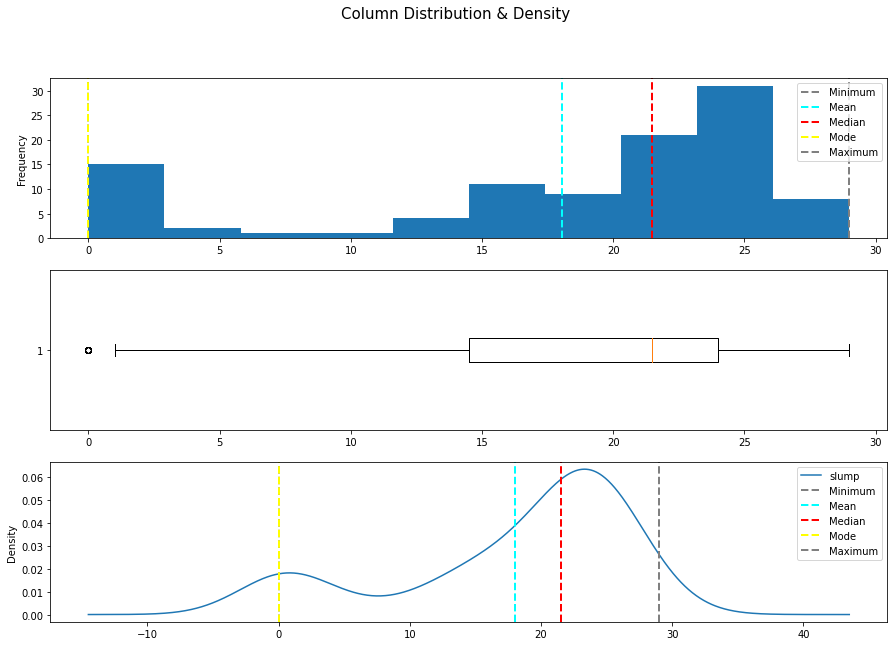

In [43]:
show_distribution_density(df['slump'])

Minimum:20.00
Mean:49.61
Median:54.00
Mode:20.00
Maximum:78.00



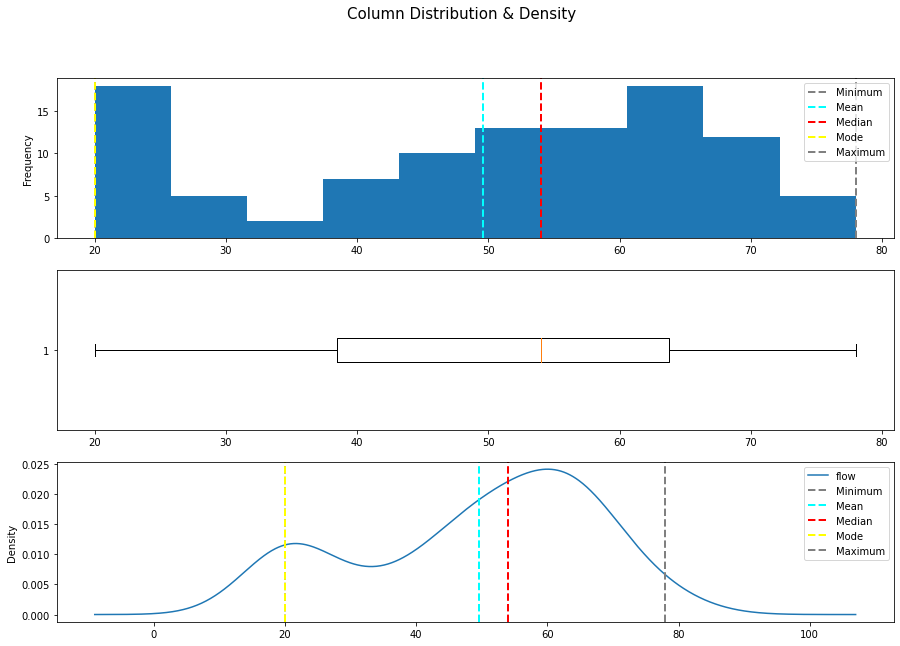

In [44]:
show_distribution_density(df['flow'])

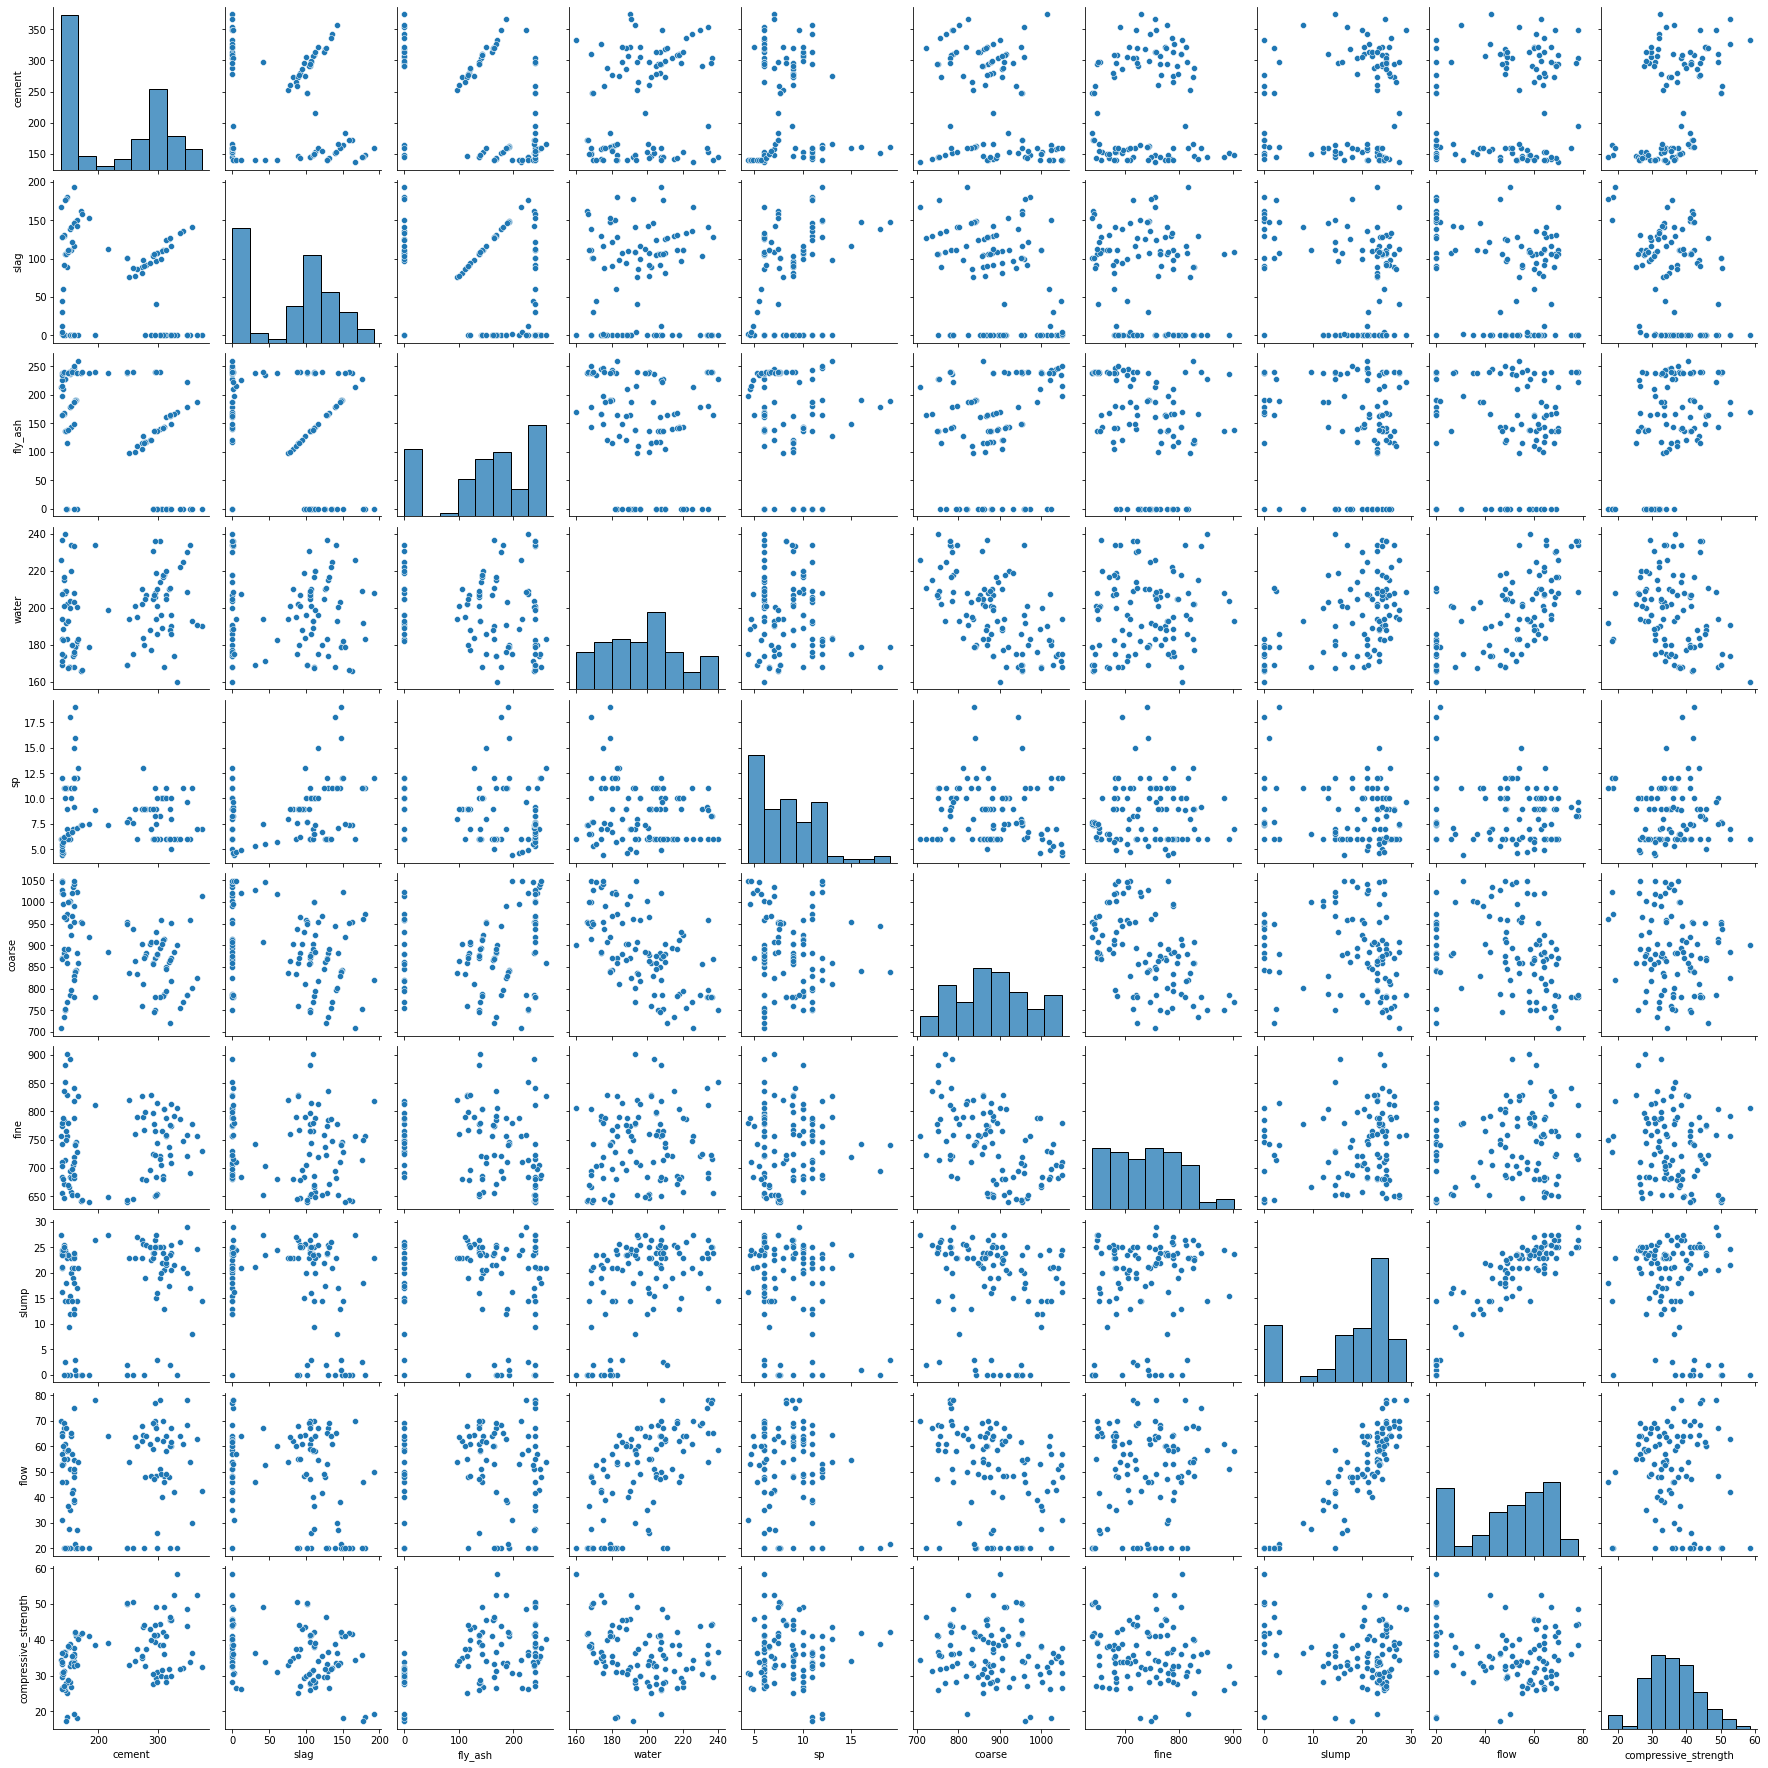

In [45]:
sns.pairplot(df)

In [46]:
df.corr()    #0 a ne kadar yakinsa iliski zayif

,cement,slag,fly_ash,water,sp,coarse,fine,slump,flow,compressive_strength
cement,1.000,-0.244,-0.487,0.221,-0.106,-0.310,0.057,0.146,0.186,0.446
slag,-0.244,1.000,-0.323,-0.027,0.307,-0.224,-0.184,-0.284,-0.327,-0.332
fly_ash,-0.487,-0.323,1.000,-0.241,-0.144,0.173,-0.283,-0.119,-0.055,0.444
water,0.221,-0.027,-0.241,1.000,-0.155,-0.602,0.115,0.467,0.632,-0.254
sp,-0.106,0.307,-0.144,-0.155,1.000,-0.104,0.058,-0.213,-0.176,-0.038
coarse,-0.310,-0.224,0.173,-0.602,-0.104,1.000,-0.489,-0.188,-0.326,-0.161
fine,0.057,-0.184,-0.283,0.115,0.058,-0.489,1.000,0.202,0.190,-0.155
slump,0.146,-0.284,-0.119,0.467,-0.213,-0.188,0.202,1.000,0.906,-0.223
flow,0.186,-0.327,-0.055,0.632,-0.176,-0.326,0.190,0.906,1.000,-0.124
compressive_strength,0.446,-0.332,0.444,-0.254,-0.038,-0.161,-0.155,-0.223,-0.124,1.000


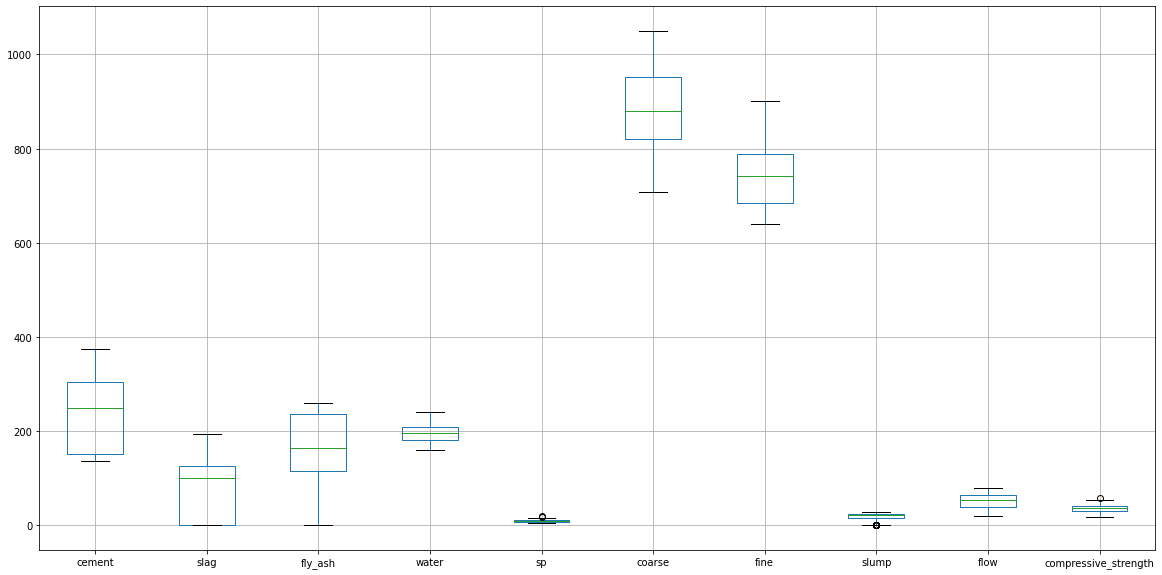

In [47]:
plt.figure(figsize =(20,10))
df.boxplot();

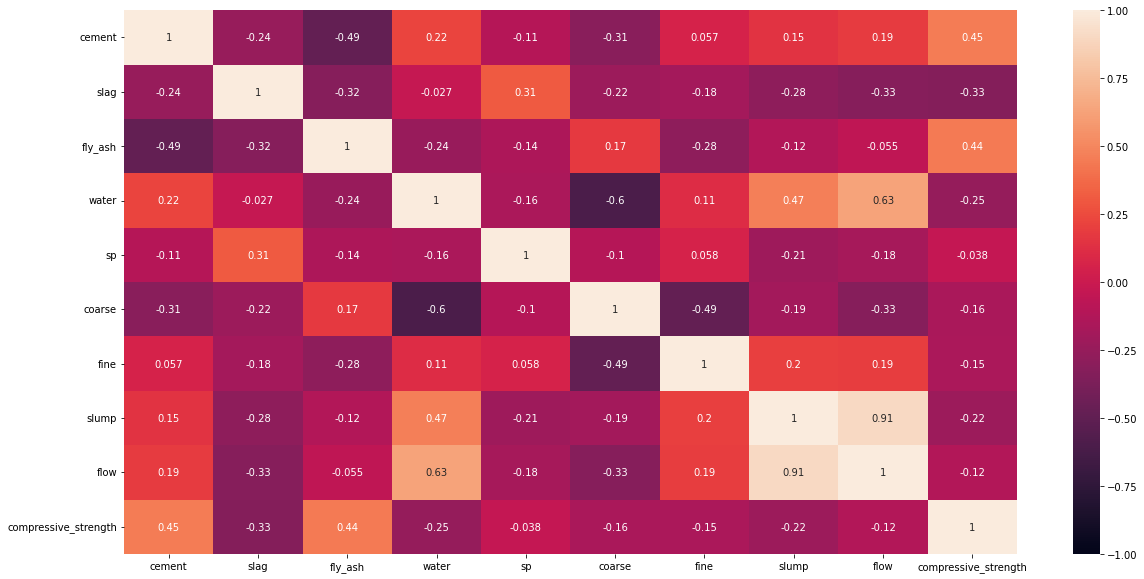

In [48]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1);

target ile predict i etkileyecek derecede corr yok aralarinda

# Data Preprocessing 

Features and target variable
Split the data into features and target variable

In [49]:
X = df.drop("compressive_strength", axis =1)
y = df["compressive_strength"]

In [50]:
from sklearn.model_selection import train_test_split

### Splitting data into training and testing
* Split the data into training and testing sets

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scaling
* import StandardScaler and scale the data. Use fit_transform() on the training set and transform() on the testing set to prevent data leakage.

In [52]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [53]:
scaler = StandardScaler()

In [54]:
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

##  1. Model Building (Linear Regression)
* Build a linear regression model, fit the model, and make predictions on the test and train set, and compare them.

In [55]:
from sklearn.pipeline import Pipeline

In [56]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

In [57]:
pipe_lm = Pipeline([("scaler", scaler), ("lm", lm)])

In [58]:
pipe_lm.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lm', LinearRegression())])

In [59]:
y_pred = pipe_lm.predict(X_test) 
y_train_pred = pipe_lm.predict(X_train)

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_val(y_train, y_train_pred, y_test, y_pred, model_name):
    
    scores = {model_name+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    model_name+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [61]:
ls =train_val(y_train, y_train_pred, y_test, y_pred, "linear") # train and test scores
ls

,linear_train,linear_test
R2,0.907,0.912
mae,1.936,1.740
mse,5.874,4.454
rmse,2.424,2.111


In [62]:
from sklearn.model_selection import cross_validate, cross_val_score

In [63]:
model = Pipeline([("scaler", scaler), ("lm", lm)])
scores = cross_validate(model, X_train, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 5)

In [64]:
pd.DataFrame(scores, index = range(1,6))

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.003,0.002,0.942,-1.909,-4.645,-2.155
2,0.003,0.003,0.707,-2.647,-10.757,-3.280
3,0.004,0.001,0.866,-1.483,-3.726,-1.930
4,0.005,0.001,0.923,-2.244,-8.434,-2.904
5,0.005,0.001,0.793,-2.868,-11.698,-3.420


In [65]:
scores = pd.DataFrame(scores, index=range(1,6))
scores.iloc[:, 2:].mean()

test_r2                             0.846
test_neg_mean_absolute_error       -2.230
test_neg_mean_squared_error        -7.852
test_neg_root_mean_squared_error   -2.738
dtype: float64

In [66]:
train_val(y_train, y_train_pred, y_test, y_pred, "linear")

,linear_train,linear_test
R2,0.907,0.912
mae,1.936,1.740
mse,5.874,4.454
rmse,2.424,2.111


In [67]:
print("train RMSE:", 2.423698/df["compressive_strength"].mean())
print("CV RMSE:", 2.737927/df["compressive_strength"].mean())

train RMSE: 0.06725257718905493
CV RMSE: 0.07597177821060941


In [68]:
pipe_lm["lm"].coef_

array([ 4.28015177, -2.22287954,  3.9320198 , -4.77083923,  0.12109966,
       -5.27729122, -2.61131342, -2.18837804,  1.46570621])

In [69]:
lm_df = pd.DataFrame(pipe_lm["lm"].coef_, columns = ["lm_coef"])
lm_df

,lm_coef
0,4.280
1,-2.223
2,3.932
3,-4.771
4,0.121
5,-5.277
6,-2.611
7,-2.188
8,1.466


In [70]:
def adj_r2(y_test, y_pred, X):
    r2 = r2_score(y_test, y_pred)
    n = X.shape[0]   
    p = X.shape[1]   
    adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
    return adj_r2

In [71]:
adj_r2(y_test, y_pred, X)

0.9034474275822458

In [72]:
from sklearn.model_selection import cross_validate, cross_val_score 
from sklearn.metrics import SCORERS

In [73]:
linear = LinearRegression()
scores = cross_validate(linear, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                             0.826
test_neg_mean_absolute_error       -2.251
test_neg_mean_squared_error        -7.923
test_neg_root_mean_squared_error   -2.721
dtype: float64

In [74]:
print(ls)

      linear_train  linear_test
R2           0.907        0.912
mae          1.936        1.740
mse          5.874        4.454
rmse         2.424        2.111


### 1.1 Interpret the model
* Interpret the model by looking at the coefficients

In [75]:
import pandas as pd

In [78]:
lm.coef_

array([ 4.28015177, -2.22287954,  3.9320198 , -4.77083923,  0.12109966,
       -5.27729122, -2.61131342, -2.18837804,  1.46570621])

In [79]:
lm.intercept_

35.84719512195121

In [80]:
my_dict = {"Actual": y_test, "Pred": y_pred, "Residual":y_test-y_pred, "LSE":(y_test-y_pred)**2, "ABS": abs(y_test-y_pred)}

In [81]:
comparing = pd.DataFrame(my_dict)
comparing

,Actual,Pred,Residual,LSE,ABS
30,45.820,44.889,0.931,0.867,0.931
67,40.340,41.416,-1.076,1.158,1.076
62,28.290,28.566,-0.276,0.076,0.276
47,43.010,39.400,3.610,13.031,3.610
42,33.510,35.143,-1.633,2.667,1.633
40,35.660,39.032,-3.372,11.370,3.372
90,35.520,37.359,-1.839,3.380,1.839
45,31.770,30.865,0.905,0.819,0.905
10,26.020,28.773,-2.753,7.578,2.753
0,34.990,34.471,0.519,0.269,0.519


### 1.2 Model Evaluation
* Evaluate the model if it is appropriate to linear regression,to do so use residuals and R-squared.

In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_val(y_train, y_train_pred, y_test, y_pred, model_name):
    
    scores = {model_name+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    model_name+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [83]:
ls =train_val(y_train, y_train_pred, y_test, y_pred, "linear")
ls

,linear_train,linear_test
R2,0.907,0.912
mae,1.936,1.740
mse,5.874,4.454
rmse,2.424,2.111


In [84]:
from sklearn.model_selection import cross_validate, cross_val_score

In [85]:
model = LinearRegression()
scores = cross_validate(model, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

In [86]:
pd.DataFrame(scores, index = range(1,11))

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.005,0.002,0.945,-1.712,-4.096,-2.024
2,0.002,0.001,0.943,-1.819,-3.996,-1.999
3,0.002,0.002,0.594,-2.811,-11.146,-3.339
4,0.004,0.001,0.688,-2.971,-14.097,-3.755
5,0.000,0.000,0.660,-2.041,-6.364,-2.523
6,0.000,0.007,0.933,-1.192,-1.874,-1.369
7,0.001,0.002,0.908,-2.579,-11.528,-3.395
8,0.003,0.002,0.915,-2.240,-8.029,-2.834
9,0.002,0.001,0.826,-2.685,-11.138,-3.337
10,0.003,0.000,0.850,-2.461,-6.958,-2.638


In [87]:
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                             0.826
test_neg_mean_absolute_error       -2.251
test_neg_mean_squared_error        -7.923
test_neg_root_mean_squared_error   -2.721
dtype: float64

In [88]:
train_val(y_train, y_train_pred, y_test, y_pred, "linear")

,linear_train,linear_test
R2,0.907,0.912
mae,1.936,1.740
mse,5.874,4.454
rmse,2.424,2.111


In [89]:
lm_df = pd.DataFrame(lm.coef_, columns = ["lm_coef"])
lm_df

,lm_coef
0,4.280
1,-2.223
2,3.932
3,-4.771
4,0.121
5,-5.277
6,-2.611
7,-2.188
8,1.466


In [90]:
residuals = y_test-y_pred

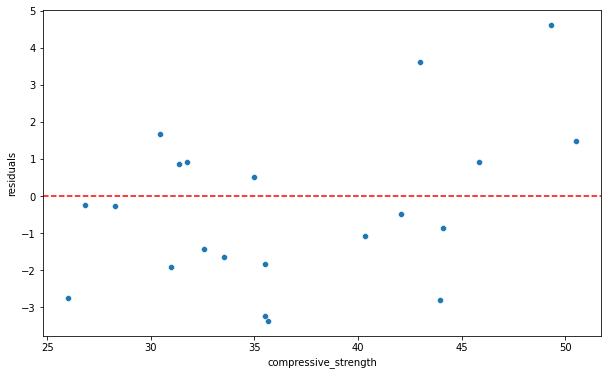

In [91]:
plt.figure(figsize = (10,6))
sns.scatterplot(x = y_test, y = residuals) 
plt.axhline(y = 0, color ="r", linestyle = "--")
plt.ylabel("residuals")
plt.show()

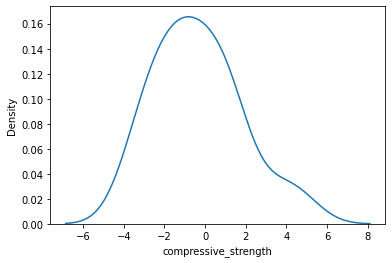

In [93]:
sns.kdeplot(residuals);

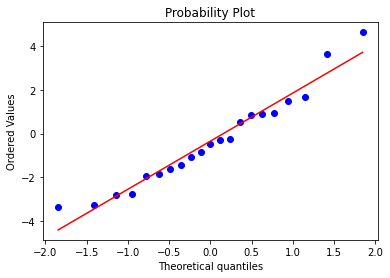

In [94]:
stats.probplot(residuals, dist ="norm", plot =plt);

In [95]:
from scipy.stats import skew
skew(residuals)

0.6026499074920363

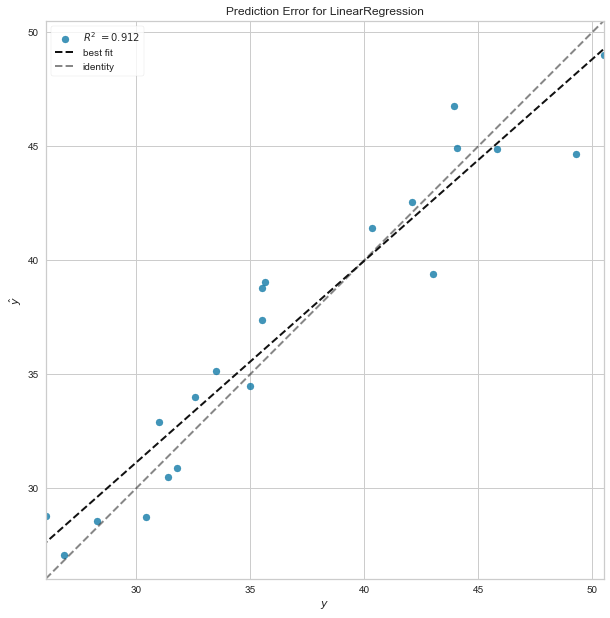

In [96]:
from yellowbrick.regressor import PredictionError
from yellowbrick.features import RadViz

visualizer = RadViz(size=(720, 3000))
model = LinearRegression()
visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show();

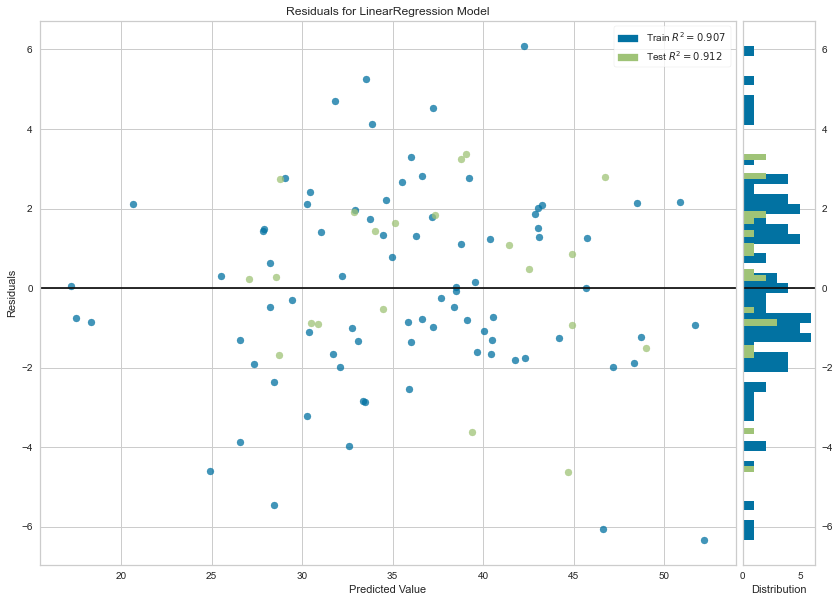

In [97]:
from yellowbrick.regressor import ResidualsPlot

visualizer = RadViz(size=(1000, 720))
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

     Actual   Pred  Residual
40   35.660 39.032    -3.372
100  50.500 49.008     1.492
62   28.290 28.566    -0.276
67   40.340 41.416    -1.076
0    34.990 34.471     0.519
10   26.020 28.773    -2.753
42   33.510 35.143    -1.633
76   32.570 34.006    -1.436
79   30.430 28.745     1.685
31   43.950 46.743    -2.793
18   49.300 44.674     4.626
30   45.820 44.889     0.931
33   35.520 38.764    -3.244
90   35.520 37.359    -1.839
85   30.970 32.896    -1.926
26   42.080 42.560    -0.480
45   31.770 30.865     0.905
47   43.010 39.400     3.610
4    26.820 27.054    -0.234
12   31.370 30.505     0.865


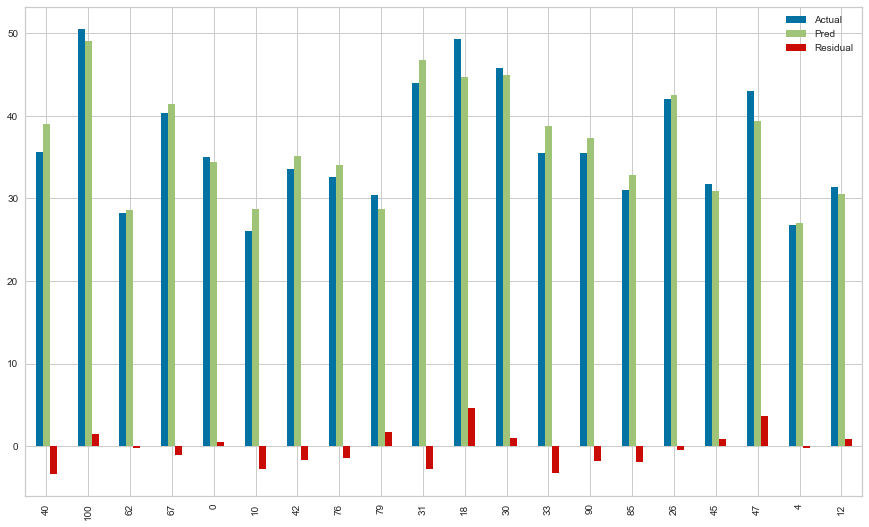

In [98]:
my_dict = { 'Actual': y_test, 'Pred': y_pred, 'Residual': y_test-y_pred }
compare = pd.DataFrame(my_dict)

comp_sample = compare.sample(20)
print(comp_sample)

comp_sample.plot(kind='bar',figsize=(15,9))
plt.show()

# 2. Regularization
* Regularize the model by adding a regularization term to the loss function.

## 2.1 Ridge (Apply and evaluate)
* Build a Ridge regression model, fit the model, and make predictions on the test and train set, and compare them.


In [99]:
from sklearn.linear_model import Ridge

In [100]:
ridge_model = Ridge(alpha=1)

In [101]:
ridge_model.fit(X_train_scaled, y_train)

Ridge(alpha=1)

In [102]:
y_pred = ridge_model.predict(X_test_scaled)
y_train_pred = ridge_model.predict(X_train_scaled)

In [103]:
rs = train_val(y_train, y_train_pred, y_test, y_pred, "ridge")
rs

,ridge_train,ridge_test
R2,0.906,0.911
mae,1.938,1.732
mse,5.922,4.493
rmse,2.434,2.120


In [104]:
pd.concat([ls, rs], axis=1)

,linear_train,linear_test,ridge_train,ridge_test
R2,0.907,0.912,0.906,0.911
mae,1.936,1.740,1.938,1.732
mse,5.874,4.454,5.922,4.493
rmse,2.424,2.111,2.434,2.120


In [105]:
from sklearn.model_selection import GridSearchCV

In [106]:
alpha_space = np.linspace(0.01, 1, 100)
alpha_space

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [107]:
ridge_model = Ridge()

In [108]:
param_grid = {"alpha":alpha_space}

In [109]:
grid_ridge = GridSearchCV(estimator = ridge_model, param_grid = param_grid, scoring = 'neg_root_mean_squared_error',
                         cv =10, verbose =2)

In [110]:
grid_ridge.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.02; total time=   0.0s
[CV] END ...................................

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='neg_root_mean_squared_error', verbose=2)

In [111]:
grid_ridge.best_params_

{'alpha': 0.92}

In [112]:
grid_ridge.best_score_

-2.696392988643865

In [113]:
y_pred = grid_ridge.predict(X_test_scaled)
y_train_pred = grid_ridge.predict(X_train_scaled)

In [114]:
rgs = train_val(y_train, y_train_pred, y_test, y_pred, "grid_ridge")
rgs

,grid_ridge_train,grid_ridge_test
R2,0.906,0.911
mae,1.938,1.732
mse,5.917,4.485
rmse,2.432,2.118


In [115]:
pd.concat([ls, rs, rgs], axis = 1)

,linear_train,linear_test,ridge_train,ridge_test,grid_ridge_train,grid_ridge_test
R2,0.907,0.912,0.906,0.911,0.906,0.911
mae,1.936,1.740,1.938,1.732,1.938,1.732
mse,5.874,4.454,5.922,4.493,5.917,4.485
rmse,2.424,2.111,2.434,2.120,2.432,2.118


In [116]:
rm = Ridge(alpha=0.92).fit(X_train_scaled, y_train) # 'GridSearchCV' object has no attribute 'coef_'
rm.coef_

array([ 5.00536166, -1.38916853,  4.79676356, -3.93112534,  0.25813578,
       -4.0917173 , -1.7629051 , -1.96963056,  1.1545175 ])

## 2.2 Lasso (Apply and evalute)
* Build a Lasso regression model, fit the model, and make predictions on the test and train set, and compare them.

In [117]:
from sklearn.linear_model import Lasso

In [118]:
lasso_model = Lasso(alpha=1)
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=1)

In [119]:
y_pred = lasso_model.predict(X_test_scaled)
y_train_pred = lasso_model.predict(X_train_scaled)

In [120]:
lss = train_val(y_train, y_train_pred, y_test, y_pred, "lasso")
lss

,lasso_train,lasso_test
R2,0.776,0.802
mae,2.960,2.466
mse,14.144,10.036
rmse,3.761,3.168


In [121]:
pd.concat([ls, rs, rgs, lss], axis = 1)

,linear_train,linear_test,ridge_train,ridge_test,grid_ridge_train,grid_ridge_test,lasso_train,lasso_test
R2,0.907,0.912,0.906,0.911,0.906,0.911,0.776,0.802
mae,1.936,1.740,1.938,1.732,1.938,1.732,2.960,2.466
mse,5.874,4.454,5.922,4.493,5.917,4.485,14.144,10.036
rmse,2.424,2.111,2.434,2.120,2.432,2.118,3.761,3.168


In [122]:
model = Lasso(alpha=1)
scores = cross_validate(model, X_train_scaled, y_train,
                        scoring=['r2', 'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)

In [123]:
pd.DataFrame(scores, index = range(1, 11))

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.002,0.001,0.841,-2.871,-11.961,-3.458
2,0.001,0.001,0.851,-2.974,-10.515,-3.243
3,0.002,0.002,0.288,-3.807,-19.544,-4.421
4,0.002,0.001,0.559,-3.283,-19.926,-4.464
5,0.002,0.001,0.378,-2.750,-11.636,-3.411
6,0.001,0.002,0.715,-2.303,-7.945,-2.819
7,0.002,0.001,0.627,-5.206,-46.574,-6.825
8,0.000,0.003,0.854,-2.611,-13.855,-3.722
9,0.002,0.002,0.711,-3.485,-18.501,-4.301
10,0.001,0.000,0.768,-2.910,-10.778,-3.283


In [124]:
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:,2:].mean()

test_r2                              0.659
test_neg_mean_absolute_error        -3.220
test_neg_mean_squared_error        -17.123
test_neg_root_mean_squared_error    -3.995
dtype: float64

In [125]:
train_val(y_train, y_train_pred, y_test, y_pred, "lasso")

,lasso_train,lasso_test
R2,0.776,0.802
mae,2.960,2.466
mse,14.144,10.036
rmse,3.761,3.168


In [126]:
lasso_model.coef_

array([ 4.82131411, -0.        ,  4.88005283, -0.81976891,  0.        ,
       -0.35149513, -0.        , -0.71063068, -0.        ])

In [127]:
lsm_df = pd.DataFrame(lasso_model.coef_, columns = ["lasso_coef_1"])

In [128]:
pd.concat([lm_df, lsm_df], axis = 1)

,lm_coef,lasso_coef_1
0,4.280,4.821
1,-2.223,-0.000
2,3.932,4.880
3,-4.771,-0.820
4,0.121,0.000
5,-5.277,-0.351
6,-2.611,-0.000
7,-2.188,-0.711
8,1.466,-0.000


In [129]:
lasso_model = Lasso(max_iter=100000)

In [130]:
param_grid = {"alpha":alpha_space}

In [131]:
grid_lasso = GridSearchCV(estimator = lasso_model, param_grid = param_grid, scoring = 'neg_root_mean_squared_error',
                         cv =10, verbose =2)

In [132]:
grid_lasso.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.02; total time=   0.0s
[CV] END ...................................

GridSearchCV(cv=10, estimator=Lasso(max_iter=100000),
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='neg_root_mean_squared_error', verbose=2)

In [133]:
grid_lasso.best_params_

{'alpha': 0.03}

In [134]:
grid_lasso.best_score_

-2.725010118649377

In [135]:
y_pred = grid_lasso.predict(X_test_scaled)
y_train_pred = grid_lasso.predict(X_train_scaled)

In [136]:
y_pred = grid_lasso.predict(X_test_scaled)
y_train_pred = grid_lasso.predict(X_train_scaled)

In [140]:
lgs = train_val(y_train, y_train_pred, y_test, y_pred, "grid_lasso")
lgs

,grid_lasso_train,grid_lasso_test
R2,0.905,0.912
mae,1.941,1.722
mse,6.003,4.439
rmse,2.450,2.107


In [141]:
lsm = Lasso(alpha=0.03).fit(X_train_scaled, y_train) 
lsm.coef_

array([ 6.34371841, -0.        ,  6.32536397, -2.88078898,  0.42506412,
       -2.38925993, -0.46619636, -1.77863685,  0.92681106])

In [142]:
pd.concat([ls, rs, rgs, lss, lgs], axis = 1)

,linear_train,linear_test,ridge_train,ridge_test,grid_ridge_train,grid_ridge_test,lasso_train,lasso_test,grid_lasso_train,grid_lasso_test
R2,0.907,0.912,0.906,0.911,0.906,0.911,0.776,0.802,0.905,0.912
mae,1.936,1.740,1.938,1.732,1.938,1.732,2.960,2.466,1.941,1.722
mse,5.874,4.454,5.922,4.493,5.917,4.485,14.144,10.036,6.003,4.439
rmse,2.424,2.111,2.434,2.120,2.432,2.118,3.761,3.168,2.450,2.107


## 2.3 Elastic-Net (Apply and evaluate )

---

* Build an Elastic-Net regression model, fit the model, and make predictions on the test and train set, and compare them.
* Use Gridsearch for hyperparameter tuning instead of ElacticnetCV

In [143]:
from sklearn.linear_model import ElasticNet

In [144]:
elastic_model = ElasticNet(alpha=1, l1_ratio=0.5)
elastic_model.fit(X_train_scaled, y_train)

ElasticNet(alpha=1)

In [145]:
y_pred = elastic_model.predict(X_test_scaled)
y_train_pred = elastic_model.predict(X_train_scaled)

In [146]:
es = train_val(y_train, y_train_pred, y_test, y_pred, "elastic")
es

,elastic_train,elastic_test
R2,0.637,0.635
mae,3.803,3.556
mse,22.982,18.466
rmse,4.794,4.297


In [147]:
df_score = pd.concat([ls,rs, rgs, lss, lgs, es], axis = 1)
df_score

,linear_train,linear_test,ridge_train,ridge_test,grid_ridge_train,grid_ridge_test,lasso_train,lasso_test,grid_lasso_train,grid_lasso_test,elastic_train,elastic_test
R2,0.907,0.912,0.906,0.911,0.906,0.911,0.776,0.802,0.905,0.912,0.637,0.635
mae,1.936,1.740,1.938,1.732,1.938,1.732,2.960,2.466,1.941,1.722,3.803,3.556
mse,5.874,4.454,5.922,4.493,5.917,4.485,14.144,10.036,6.003,4.439,22.982,18.466
rmse,2.424,2.111,2.434,2.120,2.432,2.118,3.761,3.168,2.450,2.107,4.794,4.297


In [148]:
model = ElasticNet(alpha=1, l1_ratio=0.5)
scores = cross_validate(model, X_train_scaled, y_train,
                        scoring=['r2', 'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)

In [149]:
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:,2:]

,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.623,-4.218,-28.265,-5.316
2,0.555,-4.782,-31.396,-5.603
3,0.238,-3.950,-20.920,-4.574
4,0.510,-2.980,-22.153,-4.707
5,0.237,-3.124,-14.274,-3.778
6,0.473,-3.323,-14.698,-3.834
7,0.507,-6.127,-61.599,-7.848
8,0.679,-4.149,-30.359,-5.510
9,0.599,-4.202,-25.691,-5.069
10,0.622,-3.941,-17.553,-4.190


In [150]:
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:,2:].mean()

test_r2                              0.504
test_neg_mean_absolute_error        -4.080
test_neg_mean_squared_error        -26.691
test_neg_root_mean_squared_error    -5.043
dtype: float64

In [151]:
train_val(y_train, y_train_pred, y_test, y_pred, "elastic")

,elastic_train,elastic_test
R2,0.637,0.635
mae,3.803,3.556
mse,22.982,18.466
rmse,4.794,4.297


In [152]:
elastic_model.coef_

array([ 2.61657059, -0.73015253,  2.67139945, -1.20195947,  0.        ,
       -1.16386814, -0.32234008, -0.82569551, -0.        ])

In [153]:
em_df = pd.DataFrame(elastic_model.coef_, columns=["elastic_coef_(alp:1, l1:0.5)"])

In [154]:
from sklearn.model_selection import GridSearchCV

In [155]:
elastic_model = ElasticNet(max_iter=10000)

In [156]:
param_grid = {"alpha":[0.01, 0.03, 0.2, 0.5, 0.6, 0.7, 1],
            "l1_ratio":[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]}

In [157]:
grid_model = GridSearchCV(estimator = elastic_model, param_grid = param_grid, scoring = 'neg_root_mean_squared_error',
                         cv =10)

In [158]:
grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=ElasticNet(max_iter=10000),
             param_grid={'alpha': [0.01, 0.03, 0.2, 0.5, 0.6, 0.7, 1],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_root_mean_squared_error')

In [159]:
grid_model.best_params_

{'alpha': 0.01, 'l1_ratio': 0.1}

In [160]:
pd.DataFrame(grid_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002,0.001,0.001,0.001,0.010,0.100,"{'alpha': 0.01, 'l1_ratio': 0.1}",-2.007,-1.823,-3.395,-3.696,-2.398,-1.419,-3.516,-2.736,-3.346,-2.642,-2.698,0.745,1
1,0.002,0.001,0.001,0.001,0.010,0.500,"{'alpha': 0.01, 'l1_ratio': 0.5}",-2.000,-1.832,-3.394,-3.715,-2.401,-1.419,-3.482,-2.780,-3.353,-2.659,-2.703,0.744,2
2,0.002,0.001,0.001,0.000,0.010,0.700,"{'alpha': 0.01, 'l1_ratio': 0.7}",-1.998,-1.841,-3.394,-3.725,-2.407,-1.422,-3.465,-2.806,-3.357,-2.674,-2.709,0.742,4
3,0.002,0.000,0.000,0.001,0.010,0.900,"{'alpha': 0.01, 'l1_ratio': 0.9}",-1.997,-1.857,-3.396,-3.737,-2.420,-1.430,-3.450,-2.837,-3.363,-2.706,-2.719,0.740,7
4,0.002,0.001,0.001,0.000,0.010,0.950,"{'alpha': 0.01, 'l1_ratio': 0.95}",-1.997,-1.864,-3.398,-3.740,-2.426,-1.433,-3.446,-2.847,-3.365,-2.715,-2.723,0.739,8
5,0.003,0.001,0.000,0.000,0.010,0.990,"{'alpha': 0.01, 'l1_ratio': 0.99}",-1.997,-1.871,-3.399,-3.742,-2.433,-1.437,-3.444,-2.856,-3.367,-2.727,-2.727,0.737,12
6,0.002,0.001,0.001,0.001,0.010,1,"{'alpha': 0.01, 'l1_ratio': 1}",-1.997,-1.873,-3.400,-3.743,-2.435,-1.438,-3.444,-2.859,-3.368,-2.732,-2.729,0.737,13
7,0.002,0.001,0.001,0.001,0.030,0.100,"{'alpha': 0.03, 'l1_ratio': 0.1}",-2.061,-1.806,-3.474,-3.598,-2.416,-1.483,-3.730,-2.582,-3.338,-2.608,-2.710,0.752,5
8,0.002,0.001,0.001,0.000,0.030,0.500,"{'alpha': 0.03, 'l1_ratio': 0.5}",-2.024,-1.766,-3.472,-3.639,-2.395,-1.470,-3.634,-2.673,-3.357,-2.631,-2.706,0.756,3
9,0.001,0.000,0.001,0.000,0.030,0.700,"{'alpha': 0.03, 'l1_ratio': 0.7}",-2.006,-1.747,-3.477,-3.664,-2.381,-1.475,-3.587,-2.732,-3.371,-2.659,-2.710,0.759,6


In [161]:
grid_model.best_score_

-2.6977333445406977

In [162]:
y_pred = grid_model.predict(X_test_scaled) # ElasticNet(alpha=0.01, l1_ratio=0.1)
y_train_pred = grid_model.predict(X_train_scaled)

In [163]:
train_val(y_train, y_train_pred, y_test, y_pred, "GridSearch")

,GridSearch_train,GridSearch_test
R2,0.907,0.912
mae,1.937,1.731
mse,5.908,4.470
rmse,2.431,2.114


___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___